# Predicting Exchange Rates for US Dollar to Euro

In [34]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pyramid.arima import auto_arima
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Exchange Rate Data
Exchange rate for US Dollars to Euros from the initial use of the Euro in January 2002 through August 2018 as found at https://www.federalreserve.gov/data.htm

In [2]:
# exchange rate data
USEU_raw = pd.read_csv('USD_EU.csv', header=5)

USEU_raw.head()

,Time Period,RXI$US_N.B.EU
0,2002-01-01,ND
1,2002-01-02,0.9031
2,2002-01-03,0.8992
3,2002-01-04,0.8946
4,2002-01-07,0.8931


In [3]:
USEU_data = USEU_raw

# convert index to datetime
USEU_data['Date'] = USEU_raw['Time Period']
USEU_data.index = pd.to_datetime(USEU_raw['Date'])

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_data['Rate'] = pd.to_numeric(USEU_data['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_data = USEU_data.drop(columns=['Time Period', 'RXI$US_N.B.EU', 'Date'])

# Remove NAs
USEU_data.dropna(inplace=True)

USEU_data.shape

(4189, 1)

In [4]:
USEU_data.head()

,Rate
Date,
2002-01-02,0.9031
2002-01-03,0.8992
2002-01-04,0.8946
2002-01-07,0.8931
2002-01-08,0.8925


In [5]:
USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,4189.0,1.25222,0.141234,0.8594,1.1534,1.2684,1.3494,1.601


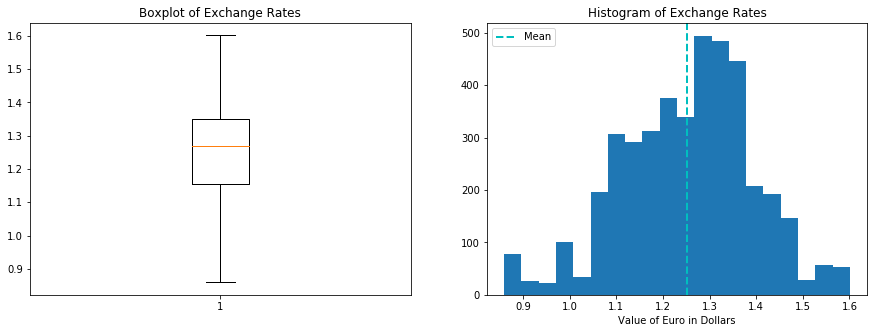

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate)
plt.title('Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate, bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Exchange Rates')
plt.show()

### Training and Test
Separate data into train and test at 70/30 split.

In [13]:
train_size = int(len(USEU_data) * 0.7)
train, test = USEU_data[0:train_size], USEU_data[train_size:len(USEU_data)]
print('Observations: %d' % (len(USEU_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 4189
Training Observations: 2932
Testing Observations: 1257


In [14]:
test.head()

,Rate
Date,
2013-08-27,1.3387
2013-08-28,1.3326
2013-08-29,1.3228
2013-08-30,1.3196
2013-09-03,1.3164


In [15]:
test.tail()

,Rate
Date,
2018-08-27,1.1676
2018-08-28,1.1720
2018-08-29,1.1699
2018-08-30,1.1646
2018-08-31,1.1596


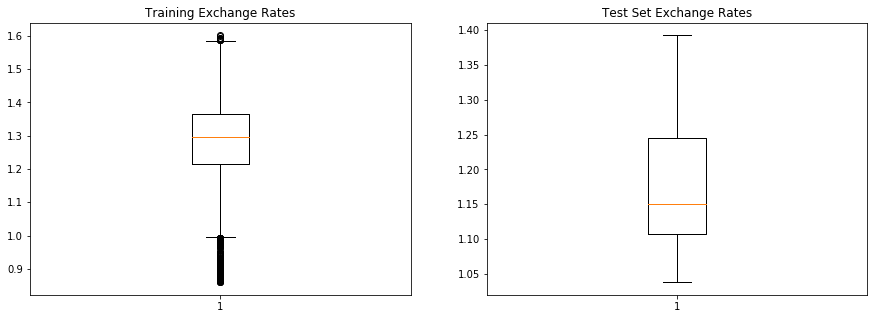

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(train.Rate.dropna(how = 'any'))
plt.title('Training Exchange Rates')

plt.subplot(1, 2, 2)
plt.boxplot(test.Rate.dropna(how = 'any'))
plt.title('Test Set Exchange Rates')

plt.show()

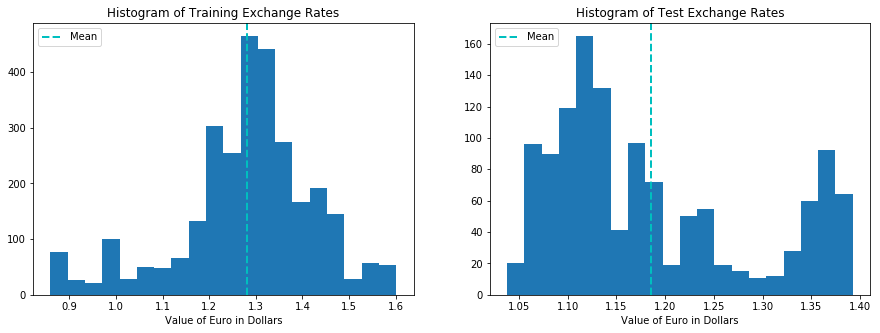

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Value of Euro in Dollars')
plt.hist(train.Rate.dropna(how = 'any'), bins=20)
plt.axvline(train.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Training Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(test.Rate.dropna(how = 'any'), bins=20)
plt.axvline(test.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Test Exchange Rates')

plt.show()

The Training data shows fairly normal distribution, while the test data does not.

# Time Series Models
The primary algorithm for time series is the ARIMA model.  The model takes three parameters: <br>
AR for auto-regressive or how the data relates to it's prior values<br>
I for integrated or the level of differencing required to make the data stationary<br>
MA for moving average or how the data relates to prior errors

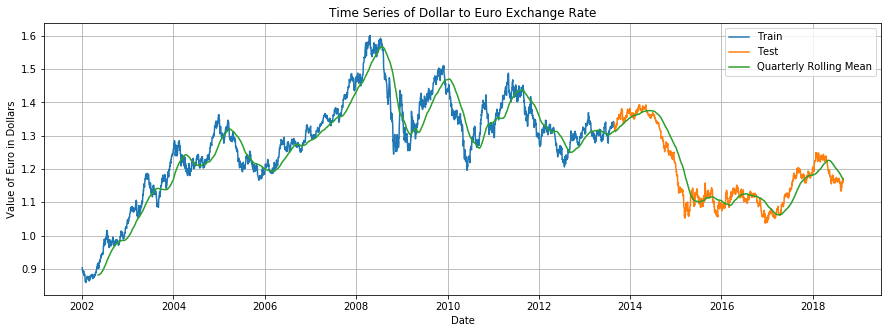

In [16]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(train['Rate'], label='Train')
plt.plot(test['Rate'], label='Test')
plt.plot(USEU_data.index, USEU_data.Rate.rolling(window=90,center=False).mean(), label = 'Quarterly Rolling Mean')
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

The value of the euro generally increased from it's initial use in 2002 through 2008.  There are then erratic rates that generally trend down through 2015.  There is a significant drop in relative value of the Euro from late 2009 to mid 2010, then again from 2014 to early 2015. <br>
This plot makes it clear visually that our data is not stationary in that it is not clustered around a single value.  By plot the difference of each data point from the prior value, we should be able to see stationality.

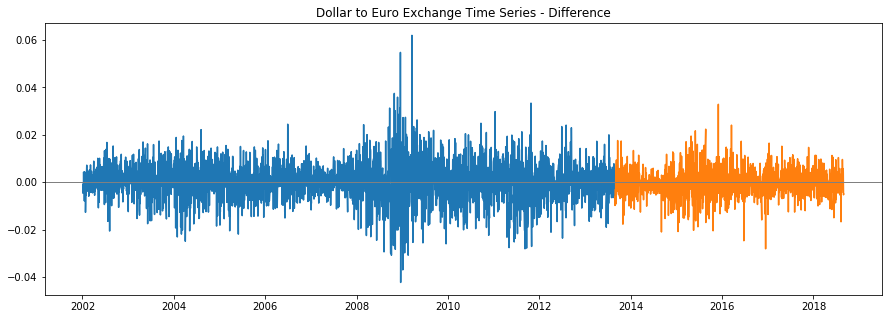

In [30]:
# difference of one record from previous next
train_diff = train.copy()
train_diff['diff_1'] = train.Rate - train.Rate.shift()

test_diff = test.copy()
test_diff['diff_1'] = test.Rate - test.Rate.shift()

plt.figure(figsize=(15, 5))
plt.plot(train.index, train_diff.diff_1)
plt.plot(test.index, test_diff.diff_1)
plt.axhline(0, color='grey', linestyle='solid', linewidth=1)
plt.title('Dollar to Euro Exchange Time Series - Difference')
plt.show()

That plot of difference shows the values custered around 0 - we have stationality in the data when taking a single level difference.  This plot also gives us insight into how our data values change from day to day.  We see greater volatility in the exchange rate in 2008 and 2009, with noticeable smaller extremes after 2009.  There is noticably more stability in the exchange rate in 2014 as less variation is seen from day to day.

We can mathematically test the stationality of the difference data using Dickey Fuller

In [27]:
# Use statsmodel's augmented Diecky Fuller test
series = train.Rate
X = series.values
result = adfuller(X)
print('Exchange Rate Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Dickey Fuller Test
Statistic: -2.612155
p-value: 0.090511
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [32]:
# Use statsmodel's augmented Diecky Fuller test
series = train_diff.diff_1.dropna()
X = series.values
result = adfuller(X)
print('Exchange Rate Difference Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Difference Dickey Fuller Test
Statistic: -53.993723
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


The Dickey Fuller test results show a much lower Statistic value for the differenced data, along with a much smaller p-value, indicating that the differenced data is stationary.

### AutoCorrelation Function (ACF) & Partial AutoCorrelation Function (PACF)
Comparing the exchange rate with a prior rates, testing for correlation.  Auto Correlation includes the impact of correlations between prior values, while the Partial Auto Correlation removes the impact of correlation to other prior values.  The values on the x-axis indicate the time-step shift.

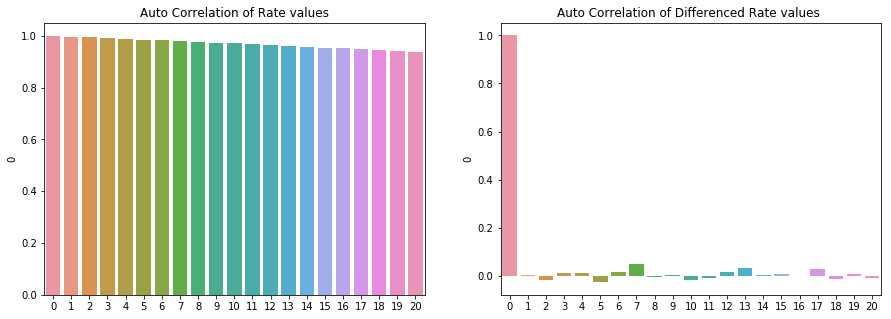

In [43]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_acf = pd.DataFrame(acf(train.Rate, nlags=20))
sns.barplot(x=x_acf.index, y=x_acf[0])
plt.title("Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_acf_diff = pd.DataFrame(acf(train_diff.diff_1[1:], nlags=20))
sns.barplot(x=x_acf_diff.index, y=x_acf_diff[0])
plt.title("Auto Correlation of Differenced Rate values ")
plt.show()

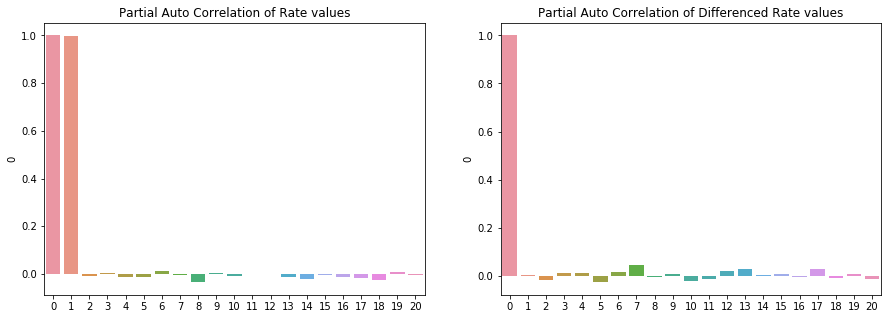

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_pacf = pd.DataFrame(pacf(train.Rate, nlags=20))
sns.barplot(x=x_pacf.index, y=x_pacf[0])
plt.title("Partial Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_pacf_diff = pd.DataFrame(pacf(train_diff.diff_1[1:], nlags=20))
sns.barplot(x=x_pacf_diff.index, y=x_pacf_diff[0])
plt.title("Partial Auto Correlation of Differenced Rate values")
plt.show()

The ACF of the original rates shows a gradual decline in correlations with increased time shifts.  The differenced data shows to auto correlation.<br>
The PACF of the original exchange rate values shows strong auto-correlation at 1.  The PACF of the exchange rate difference values shows no notable correlation.  <br>
Since it's the differenced data that we need for stationality, our model will likely perform best with parameters of 0 for the AR and MA elements.

## ARIMA model

### Seasonality
Using decomposition to identify trends and seasonality

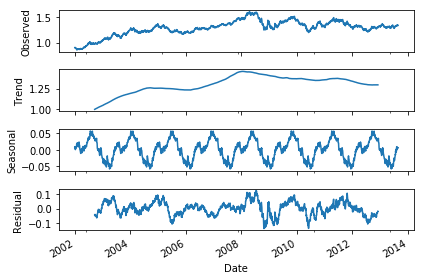

In [52]:
series = train.Rate

result_add = seasonal_decompose(series, model='additive', freq=365)
result_add.plot()
pyplot.show()

Trend is not linear, try multiplicative decomposition.

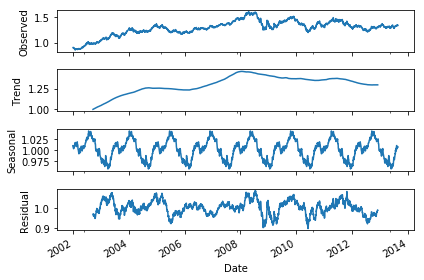

In [70]:
result_multi = seasonal_decompose(series, model='multiplicative', freq=365)
result_multi.plot()
pyplot.show()

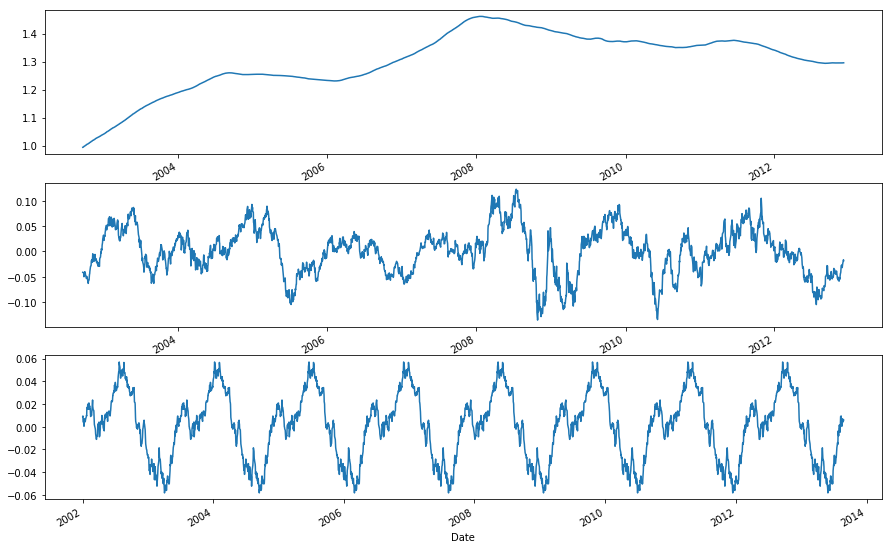

In [71]:
result_add = seasonal_decompose(series, model='additive', freq=365)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
result_add.trend.plot(ax=ax1)
result_add.resid.plot(ax=ax2)
result_add.seasonal.plot(ax=ax3)
plt.show()

### Using Auto Arima to for optimal test parameters

In [46]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-19736.188, BIC=-19724.222, Fit time=0.084 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-19734.202, BIC=-19716.253, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-19734.203, BIC=-19716.253, Fit time=0.051 seconds
Total fit time: 0.531 seconds
-19736.18795990398


As anticipated, the ARIMA model of (0,1,0) works best, as indicated by the (lowest) AIC value, the measure of the relative statistical quality of the model.

### Using Auto Arima with seasonality to test for optimal parameters

In [47]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-19736.188, BIC=-19724.222, Fit time=0.469 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-19733.139, BIC=-19709.207, Fit time=2.579 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-19733.178, BIC=-19709.246, Fit time=3.118 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-19735.130, BIC=-19717.181, Fit time=1.286 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=-19735.169, BIC=-19717.220, Fit time=1.894 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=-19732.810, BIC=-19708.878, Fit time=4.588 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-19734.202, BIC=-19716.253, Fit time=0.559 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=-19734.202, BIC=-19716.253, Fit time=0.422 seconds
Fit ARIM

In [74]:
train_step_model = auto_arima(train.Rate, seasonal=True,
                           m = 24, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 24); AIC=-19729.394, BIC=-19681.529, Fit time=27.670 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=-19736.188, BIC=-19724.222, Fit time=0.379 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=-19733.701, BIC=-19709.769, Fit time=5.975 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=-19733.607, BIC=-19709.674, Fit time=7.392 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=-19735.695, BIC=-19717.745, Fit time=8.150 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 24); AIC=-19735.598, BIC=-19717.649, Fit time=17.604 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 24); AIC=-19733.660, BIC=-19709.728, Fit time=15.958 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=-19734.202, BIC=-19716.253, Fit time=0.888 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 24); AIC=-19734.202, BIC=-19716.253, Fit time=0.6

In [ ]:

series = Series.from_csv('daily-total-female-births.csv', header=0)
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

### Training the model and Testing

In [37]:
# fit the model
model_010 = ARIMA(train.Rate, order=(0,1,0))
model_010_fit = model_010.fit()
print(model_010_fit.summary())
print('Residuals Description')
print(model_010_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2931
Model:                 ARIMA(0, 1, 0)   Log Likelihood                9870.094
Method:                           css   S.D. of innovations              0.008
Date:                Thu, 13 Sep 2018   AIC                         -19736.188
Time:                        08:42:00   BIC                         -19724.222
Sample:                             1   HQIC                        -19731.879
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.961      0.337      -0.000       0.000
Residuals Description
count    2.931000e+03
mean     1.260109e-10
std      8.343676e-03
min     -4.244800e-02
25%     -4.248004e-03

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# https://machinelearningmastery.com/make-sample-forecasts-arima-python/